In [4]:
import pandas as pd
import numpy as np

## Load the client data
client_df = pd.read_csv('data_files/client.csv')
#client_arr = np.array(client_df)

## Load the invoice data
invoice_df = pd.read_csv('data_files/invoice.csv')
#invoice_arr = np.array(invoice_df)


In [5]:
# Convert date columns to datetime format
client_df['date'] = pd.to_datetime(client_df['date'], errors='coerce')
invoice_df['date'] = pd.to_datetime(invoice_df['date'], errors='coerce')

# Check if any date conversions failed (i.e., resulted in NaT)
print(client_df[client_df['date'].isna()])
print(invoice_df[invoice_df['date'].isna()])


Empty DataFrame
Columns: [region, date, dis, id, catg, target]
Index: []
Empty DataFrame
Columns: [id, date, tarif_type, counter_statue, reading_remarque, consommation_level_4, months_number, counter_type, counter_coefficient, consommation_level_1, consommation_level_2, consommation_level_3]
Index: []


/var/folders/t2/_hypj1cj7gj6b3j_nd6zhsgr0000gn/T/ipykernel_22169/3500470762.py:2: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  client_df['date'] = pd.to_datetime(client_df['date'], errors='coerce')
/var/folders/t2/_hypj1cj7gj6b3j_nd6zhsgr0000gn/T/ipykernel_22169/3500470762.py:3: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  invoice_df['date'] = pd.to_datetime(invoice_df['date'], errors='coerce')


In [6]:
## Identify missing data

print(client_df.isnull().sum())
print(invoice_df.isnull().sum())

region    0
date      0
dis       0
id        0
catg      0
target    0
dtype: int64
id                      0
date                    0
tarif_type              0
counter_statue          0
reading_remarque        0
consommation_level_4    0
months_number           0
counter_type            0
counter_coefficient     0
consommation_level_1    0
consommation_level_2    0
consommation_level_3    0
dtype: int64


It can be observed that there are no missing data!

In [7]:
## Merging data sets based on id variable

merged_df = pd.merge(invoice_df, client_df, on='id', how='inner')
#merged_arr = np.array(merged_df)

## Preview the merged dataframe
print(merged_df.head())


   id     date_x  tarif_type  counter_statue  reading_remarque  \
0   0 2014-03-24          11               0                 8   
1   0 2013-03-29          11               0                 6   
2   0 2015-03-23          11               0                 8   
3   0 2015-07-13          11               0                 8   
4   0 2016-11-17          11               0                 9   

   consommation_level_4  months_number counter_type  counter_coefficient  \
0                     0              4         ELEC                    1   
1                     0              4         ELEC                    1   
2                     0              4         ELEC                    1   
3                     0              4         ELEC                    1   
4                     0             12         ELEC                    1   

   consommation_level_1  consommation_level_2  consommation_level_3  region  \
0                    82                     0                     0

In [8]:
# Converting counter_statue into a categorical variable
merged_df['counter_statue'] = merged_df['counter_statue'].astype('category').cat.codes

# Adding a new column for year and month for each row
merged_df['year'] = merged_df['date_x'].dt.year
merged_df['month'] = merged_df['date_x'].dt.month

In [9]:
from sklearn.model_selection import train_test_split

# Define features and target
xval = merged_df.drop(columns=['target','date_x', 'date_y', 'counter_type'])
yval = merged_df['target']

# Split the data train and test sets
xtrain, xtest, ytrain, ytest = train_test_split(xval, yval, test_size=0.3, random_state=0)

print('xtrain shape:', xtrain.shape)
print('xtest shape:', xtest.shape)
print('ytrain shape:', ytrain.shape)
print('ytest shape:', ytest.shape)

xtrain shape: (350455, 15)
xtest shape: (150196, 15)
ytrain shape: (350455,)
ytest shape: (150196,)


NOTE TO SELF: 
Current task is to standardise the data, but need to be mindful of DATE column

In [10]:
## Standardising the train and test data

from sklearn.preprocessing import StandardScaler
std_x = StandardScaler()
xtrain = std_x.fit_transform(xtrain)
xtest = std_x.transform(xtest)

print('xtrain shape:', xtrain.shape)
print('xtest shape:', xtest.shape)

xtrain shape: (350455, 15)
xtest shape: (150196, 15)


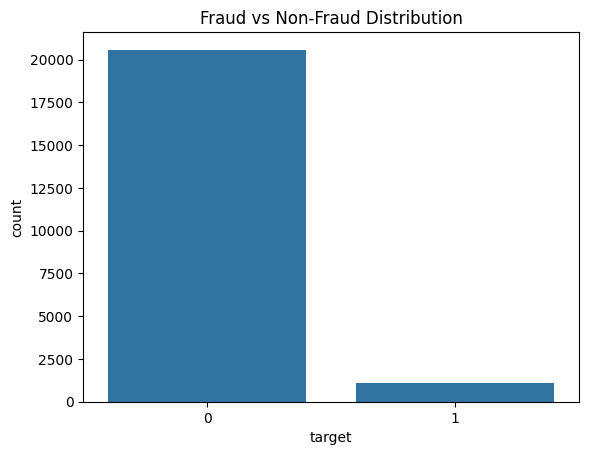

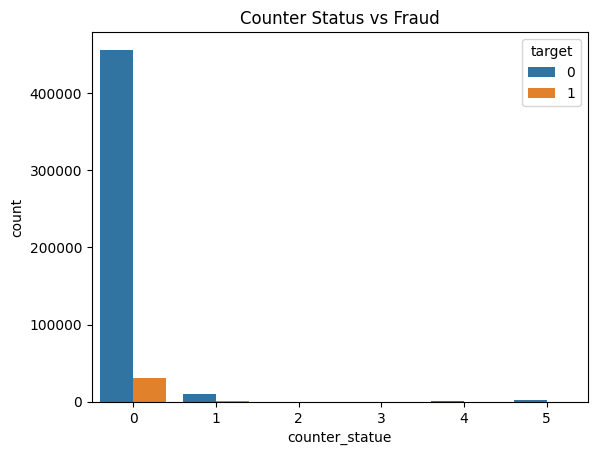

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualize fraud distribution
sns.countplot(x='target', data=client_df)
plt.title('Fraud vs Non-Fraud Distribution')
plt.show()

# Visualize counter status and its impact on fraud
sns.countplot(x='counter_statue', hue='target', data=merged_df)
plt.title('Counter Status vs Fraud')
plt.show()

TRAINING LOGISTIC REGRESSION MODEL


In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Initialize the logistic regression model
logit_reg = LogisticRegression(random_state=0)

# Fit the model to the training data
logit_reg.fit(xtrain, ytrain)

LogisticRegression(random_state=0)

In [14]:
y_pred = logit_reg.predict(xtest)

# Print evaluation metrics
print("Accuracy:", accuracy_score(ytest, y_pred))
print("Confusion Matrix:\n", confusion_matrix(ytest, y_pred))
print("Classification Report:\n", classification_report(ytest, y_pred))

Accuracy: 0.9374350848224986
Confusion Matrix:
 [[140798     13]
 [  9384      1]]
Classification Report:
               precision    recall  f1-score   support

           0       0.94      1.00      0.97    140811
           1       0.07      0.00      0.00      9385

    accuracy                           0.94    150196
   macro avg       0.50      0.50      0.48    150196
weighted avg       0.88      0.94      0.91    150196



In [16]:
# Retrieve feature names (after scaling)
feature_names = merged_df.drop(columns=['target', 'id', 'date_x', 'date_y']).columns

# Print coefficients with feature names
for feature, coef in zip(feature_names, logit_reg.coef_[0]):
    print(f"{feature}: {coef:.4f}")

tarif_type: -0.0474
counter_statue: -0.0166
reading_remarque: 0.0231
consommation_level_4: 0.0342
months_number: -0.0268
counter_type: -0.9813
counter_coefficient: -0.2804
consommation_level_1: 0.0523
consommation_level_2: 0.0050
consommation_level_3: 0.1262
region: 0.1203
dis: 0.2671
catg: 0.1266
year: -0.0182
month: -0.0119


In [20]:
from sklearn.neighbors import KNeighborsClassifier

# Initialize the KNN classifier
k = 5  # You can choose any number for k
knn = KNeighborsClassifier(n_neighbors=k)

# Fit the model
knn.fit(xtrain, ytrain)

# Make predictions on the test set
y_pred = knn.predict(xtest)

print("Accuracy:", accuracy_score(ytest, y_pred))
print("Confusion Matrix:\n", confusion_matrix(ytest, y_pred))
print("Classification Report:\n", classification_report(ytest, y_pred))

Accuracy: 0.9347918719539802
Confusion Matrix:
 [[140096    715]
 [  9079    306]]
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.99      0.97    140811
           1       0.30      0.03      0.06      9385

    accuracy                           0.93    150196
   macro avg       0.62      0.51      0.51    150196
weighted avg       0.90      0.93      0.91    150196

